Aim: Predict Rating from Review using basic and deep models

In [1]:
import re
import nltk

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import SGDClassifier, SGDRegressor
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
#https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones

## Preprocessing Function

Here is the process :
* Remove the non Letters
* Convert everything to lower case
* Remove stop words
* Stem the words

In [3]:
def review_to_wordlist( review, remove_stopwords=True):
    # Data Pre-processing
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    #
    # 1. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    #
    # 2. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 3. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(['those', 'ourselves', 'off', 'only', 'other', 'very', \
            're', 'over', 'should', 'mightn', 'then', 'where', 'some', 'aren', \
            'to', 'couldn', 'theirs', 'mustn', 'our', 'did', 'before', \
            'himself', 'her', 'needn', "aren't", 'him', 'she', 'he', 'through',\
            'shan', 'by', 'into', "didn't", 'myself', "should've", "wouldn't",\
            'if', 'they', 'same', 'wouldn', 'am', 'its', 'which', 'each',\
            'under', 'is', 'once', 'a', 'out', 'few', 'all', 'do', 'haven',\
            'an', 'yours', 'while', 'both', 've', 'what', 'ain', 'herself',\
            'themselves', 'for', 'will', 'have', "mustn't", 'more', 'that',\
            'ours', 'hers', 'doesn', 'no', 'your', 'just', 'below', 'll','isn',\
            'has', "don't", 'does', 'don', 'can', 'won', 'in', 'than', 'were',\
            'didn', "mightn't", "wasn't", 'd', 'against', 'most', 'been',\
            'during', "shan't", 'this', 'on', 'weren', 'hasn', 'up', 'be',\
            "it's", 'shouldn', 'these', 'so', 'because', 'm', "isn't",\
            "doesn't", 'here', 'and', 'we', 'between', 'itself', 'doing','you',\
            "haven't", 'his', 'after', 'as', 'until', 'own', "shouldn't",\
            'above', 'or', 'who', 'why', 'nor', 'it', 'again', 'yourselves',\
            'their', "that'll", "couldn't", "you're", 'how', 'my', 'down', 'o',\
            'me', 'further', 'whom', 'of', "you'll", "hasn't", 'being', 'i',\
            'now', 'at', 'the', "hadn't", 'wasn', 'with', 'ma', 'had',\
            "needn't", 'having', "you'd", 'there', "you've", 't',\
            'about', 'any', 'such', 'are', "won't", 'y', 'hadn', 'yourself',\
            's', 'was', 'but', 'too', "she's", "weren't", 'when', 'from', 'them'])
        words = [w for w in words if not w in stops]

    b=[]
    stemmer = english_stemmer #PorterStemmer()
    for word in words:
        b.append(stemmer.stem(word))

    # 4. Return a list of words
    return(b)

## Import Datas

We import only 20000 lines of our total data in order to run the notebook faster

In [4]:
data_file = '~/Downloads/Amazon_Unlocked_Mobile.csv'

n = 413000  
s = 20000 # 20000 
skip = sorted(random.sample(range(1,n),n-s))

data = pd.read_csv( data_file, delimiter = ",", skiprows = skip)

In [5]:
data.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Just got this phone and it is a great phone. I...,0.0
2,[XMAS DEAL] [New Edition] Jethro [SC213V2] Fli...,Jethro,79.99,5,This phone was purchased for my father. I real...,15.0
3,[XMAS DEAL] [New Edition] Jethro [SC213V2] Fli...,Jethro,79.99,2,the phone is unable to maintain signal after 2...,1.0
4,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,2,"sound quality poor, no speaker phone",0.0
5,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,5,Thank you,1.0
6,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,5,With a little bit of effort I was able to fami...,11.0
7,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,2,We bought the phone for my 92 year old mother ...,0.0
8,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,5,It's just what we were looking for,1.0
9,10.6'' Inch E-passion Unlocked Smart Phone +Ta...,e passion,99.95,1,This item is not worth the money I paid. cant ...,1.0


In [6]:
# drop useless columns
data = data.drop(columns=['Product Name', 'Brand Name', 'Price', 'Review Votes'])

In [7]:
data = data[data['Reviews'].isnull()==False]

def partition(x):
    if x < 4:
        return 0 # 'negative'
    return 1 # 'positive'

data['Rating'] = data['Rating'].map(partition)

print(data.shape)
data.head(10)

(20839, 2)


,Rating,Reviews
0,0,"Phone looks good but wouldn't stay charged, ha..."
1,1,Just got this phone and it is a great phone. I...
2,1,This phone was purchased for my father. I real...
3,0,the phone is unable to maintain signal after 2...
4,0,"sound quality poor, no speaker phone"
5,1,Thank you
6,1,With a little bit of effort I was able to fami...
7,0,We bought the phone for my 92 year old mother ...
8,1,It's just what we were looking for
9,0,This item is not worth the money I paid. cant ...


In [8]:
train, test = train_test_split(data, test_size = 0.3)

## Labels Exploration

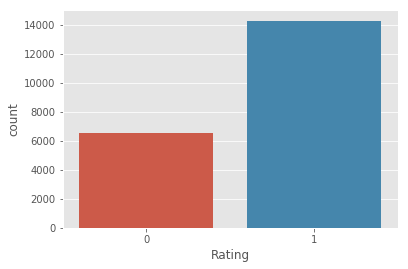

In [9]:
sns.countplot(data['Rating'])

Much More 5 than others ratings

### Apply Preprocessing

In [10]:
clean_train_reviews = []
for review in train['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))

clean_test_reviews = []
for review in test['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))

## TFidf transformation

### TFidf

We will use tfidf transformation with ngrams between 1 and 4.

In [11]:
# Why we use sublinear_tf(replacing tf with 1 + log(tf))
# Problem : It seems unlikely that twenty occurrences of a term in a document truly carry
# twenty times the significance of a single occurrence
# Reference : https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 200000, ngram_range = ( 1, 4 ),
                              sublinear_tf = True )

vectorizer = vectorizer.fit(clean_train_reviews)
train_features = vectorizer.transform(clean_train_reviews)

test_features = vectorizer.transform(clean_test_reviews)

In [12]:
print("train_features.shape : ", train_features.shape)
print("test_features.shape : ", test_features.shape)
print(train_features)

train_features.shape :  (14587, 76959)
test_features.shape :  (6252, 76959)
  (0, 76374)	0.0960108835144
  (0, 76243)	0.0543412995744
  (0, 76232)	0.0760865590772
  (0, 76018)	0.0745063418633
  (0, 73139)	0.099012582053
  (0, 73136)	0.10369237326
  (0, 72832)	0.0545845292994
  (0, 72628)	0.0960108835144
  (0, 72588)	0.0864502302302
  (0, 72493)	0.0683504122605
  (0, 70353)	0.0917802270397
  (0, 70345)	0.0525760746984
  (0, 70087)	0.0472786081809
  (0, 69644)	0.0638779388487
  (0, 69553)	0.0627426808098
  (0, 68922)	0.0936825852434
  (0, 68913)	0.071230920439
  (0, 68603)	0.0429103929817
  (0, 68176)	0.0568882478589
  (0, 67228)	0.143151991144
  (0, 67214)	0.102920790471
  (0, 67002)	0.0487454518814
  (0, 63853)	0.0936825852434
  (0, 63847)	0.0991302829911
  (0, 63405)	0.0917802270397
  :	:
  (14586, 20951)	0.144700331349
  (14586, 20950)	0.126165440364
  (14586, 20938)	0.0619014249669
  (14586, 19347)	0.0943997279374
  (14586, 14935)	0.113015056229
  (14586, 14929)	0.058980248878
  (14

### LSTM

The forward pass of a RNN is the same as the one of a MLP except that outputs from hidden layers are also used as inputs from the same layer. That means that the input from the hidden layer is both the outputs from the hidden layer one step back in time and the external input. So we have the equation:


\begin{equation} 
a_{h,t} = \sum_{i}{w_{i,h}*x_{i,t}} + \sum_{h'}{w_{h',h}*b_{h',t-1}} 
\end{equation} 


\begin{equation} 
b_{h,t} = \phi_{h}(a_{h,t}) 
\end{equation} 


where: 
* $x_{t,i} =$ value of input i at time t 
* $a_{t,j} =$ network input to unit j at time t 
* $b_{t,j}=$ output of activation of unit j at time t
* $w_{i,h} =$  weights of the network

Long Short Term Memory networks – usually just called LSTM – are a special kind of RNN, capable of learning long-term dependencies. (The idea behind those is to counter the vanishing problem of some basic RNN.)

Thus, LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In [13]:
max_features = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
maxlen = 30
batch_size = 32
nb_classes = 2

In [14]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['Reviews'])
sequences_train = tokenizer.texts_to_sequences(train['Reviews'])
sequences_test = tokenizer.texts_to_sequences(test['Reviews'])

In [15]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

y_train = np.array(train['Rating'])
y_test = np.array(test['Rating'])

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (14587, 80)
X_test shape: (6252, 80)


In [25]:
print(sequences_train[0])
print(X_train)

[26, 23, 5, 12, 1887, 11, 1, 3128, 479, 4, 430, 198, 448, 1802, 1940, 443, 20, 120, 7, 105, 6, 1708, 35, 129, 37, 20, 85, 143, 7, 1033, 3, 4, 764, 7, 644, 1599, 32, 30, 7, 96, 587, 2797, 122, 4656, 1709, 7, 663, 14, 956, 587, 6469, 736, 83, 46, 2, 5350, 7, 316, 10, 1, 663, 2, 27, 7, 147, 293, 563, 5, 6470, 7, 506, 214, 28, 228, 229, 7, 318, 3, 6, 337, 494, 1, 205, 17, 2, 2675, 6, 5351, 1438, 730, 179, 48, 13, 29, 8727, 16, 129, 179, 495, 297, 1, 638, 16, 1223, 1546, 73, 1, 833, 1101, 691, 2489, 84, 105, 9, 172, 376, 12, 1, 329, 108, 1062, 8728, 268, 36, 4657, 14, 8729, 7, 122, 70, 2, 51, 8730, 283, 39, 173, 1326, 406, 32, 1350, 61, 9, 8731, 8, 13, 1710, 2, 48, 150, 21, 104, 4164, 663, 139, 32, 42, 284, 1160, 57, 48, 40, 21, 1709, 7, 393, 3, 293, 1, 287, 79, 2, 639, 834, 20, 52, 1372, 1, 136, 194, 92, 542, 1845, 4, 3556, 2956, 7, 455, 1250, 2, 40, 140, 283, 173, 342, 212, 1063, 5352, 1642, 563, 5, 6470, 21, 84, 1709, 7, 480, 1, 329, 108, 10, 2798, 11, 1761, 76, 6471, 34, 2, 21, 89, 84, 

The embedding layer in text mining is really important. Indeed, it is a way to map our text input into a space (a dictionary of dimension here 128). The layer is trained through iterations (epochs) to have a better weights for the dictionary that allow to minimize the global error of the network.

Skip-gram, CBOW, and GloVe (or any other word2vec variant) are pre-trained word embeddings which can be set as the weight of an embedding layer. If the weight of this layer (generally the first layer of the network) is not initialized by these pre-trained vectors, the model/network itself would assign random weights and will learn the embeddings (i.e. weights) on the fly.

Explanation summarized from :
https://github.com/fchollet/keras/issues/3110

In [17]:
epochs = 1

In [29]:
from keras.layers import SpatialDropout1D
from keras import optimizers

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SpatialDropout1D(rate=0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))

sgd = optimizers.SGD(lr=0.10)
model.compile(loss='binary_crossentropy',
              optimizer= sgd,
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test, Y_test))
loss, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test loss:', loss)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

Build model...
Train...
Train on 14587 samples, validate on 6252 samples
Epoch 1/20
14587/14587 [==============================] - 86s 6ms/step - loss: 0.6007 - acc: 0.6804 - val_loss: 0.5615 - val_acc: 0.6991
Epoch 2/20
14587/14587 [==============================] - 82s 6ms/step - loss: 0.5720 - acc: 0.6891 - val_loss: 0.5450 - val_acc: 0.7422
Epoch 3/20
14587/14587 [==============================] - 80s 5ms/step - loss: 0.5336 - acc: 0.7281 - val_loss: 0.4836 - val_acc: 0.7410
Epoch 4/20
14587/14587 [==============================] - 82s 6ms/step - loss: 0.4797 - acc: 0.7683 - val_loss: 0.4242 - val_acc: 0.8217
Epoch 5/20
14587/14587 [==============================] - 81s 6ms/step - loss: 0.4308 - acc: 0.8041 - val_loss: 0.3810 - val_acc: 0.8353
Epoch 6/20
14587/14587 [==============================] - 83s 6ms/step - loss: 0.3983 - acc: 0.8215 - val_loss: 0.3508 - val_acc: 0.8581
Epoch 7/20
14587/14587 [==============================] - 84s 6ms/step - loss: 0.3727 - acc: 0.8403 - val

In [19]:
print('prediction 7 accuracy: ', accuracy_score(test['Rating'], preds))

prediction 7 accuracy:  0.894113883557


Add epochs and reviews to be more accurate with LSTM

In [20]:
# save model
model.save('./review.h5')

In [21]:
print(X_train)

[[1709    7  480 ...,  491  262  519]
 [   0    0    0 ...,  123   25   23]
 [   0    0    0 ...,    0  108  527]
 ..., 
 [   0    0    0 ...,   13   14  129]
 [  23  609   10 ...,    6  277  230]
 [ 122   17 4090 ...,    6   23    5]]


In [22]:
y_prob = model.predict(X_train[0:1])
y_class = np.argmax(y_prob, axis=1)
print(y_prob)
print(y_class)

[[ 0.93779212  0.06441101]]
[0]


In [26]:
print(X_train[0:1].shape)
print(X_train)
print(X_train.shape)

(1, 80)
[[1709    7  480 ...,  491  262  519]
 [   0    0    0 ...,  123   25   23]
 [   0    0    0 ...,    0  108  527]
 ..., 
 [   0    0    0 ...,   13   14  129]
 [  23  609   10 ...,    6  277  230]
 [ 122   17 4090 ...,    6   23    5]]
(14587, 80)


In [24]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)